In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D,Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, Add, Layer,Concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ReduceLROnPlateau



In [2]:
# Data preprocessing steps
data = pd.read_csv('TCS.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

period= 5
# roc
data['roc'] = ((data['Close'] - data['Close'].shift(period)) / data['Close'].shift(period)) * 100
# rsi
data['change_wrt_prevday'] = data['Close']- data['Close'].shift(1)

data['gain']=np.where(data['change_wrt_prevday'] >= 0,data['change_wrt_prevday'], 0)
data['loss']=np.where(data['change_wrt_prevday'] < 0,-data['change_wrt_prevday'], 0)

data['avg_gain'] = data['gain'].rolling(window=period).mean()
data['avg_loss'] = data['loss'].rolling(window=period).mean()

data['rsi'] = 100 - (100 / (1 + (data['avg_gain'] / data['avg_loss'])))# Bollinger bands

data['SMA'] = data['Close'].rolling(window=period).mean()
data['SD'] = data['Close'].rolling(window=period).std()

data['UB'] = data['SMA'] + 2* data['SD']
data['LB'] = data['SMA'] - 2* data['SD']
data['bb'] = data['UB']-data['LB']

# ROC, RSI, Bollinger Bands calculations
# (Your code for calculating these features remains the same)

data=data[['Date','Open','High','Low','Volume','Close','Adj Close','roc','rsi','bb']]
data = data.dropna(subset=['rsi'])
data = data.fillna(0)
data=data.reset_index(drop=True)



In [3]:
# Time2Vec implementation remains the same
class Time2Vec(Layer):
    def __init__(self, kernel_size=2, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.wl = self.add_weight(name='wl', shape=(1, self.kernel_size),
                                  initializer='uniform', trainable=True)
        self.bl = self.add_weight(name='bl', shape=(1, self.kernel_size),
                                  initializer='uniform', trainable=True)
        self.wp = self.add_weight(name='wp', shape=(1, self.kernel_size),
                                  initializer='uniform', trainable=True)
        self.bp = self.add_weight(name='bp', shape=(1, self.kernel_size),
                                  initializer='uniform', trainable=True)
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs):
        time_linear = self.wl * inputs + self.bl
        time_periodic = tf.math.sin(tf.matmul(inputs, self.wp) + self.bp)
        return Concatenate()([time_linear, time_periodic])

timedata = data['Date'].values.reshape(-1, 1).astype(float)
time_tensor = tf.convert_to_tensor(timedata, dtype=tf.float32)

time2vec_layer = Time2Vec(kernel_size=4)
time2vec_output = time2vec_layer(time_tensor)

time2vec_df = pd.DataFrame(time2vec_output.numpy(), columns=[f'Time2Vec{i}' for i in range(time2vec_output.shape[1])])
final_data = pd.concat([data, time2vec_df], axis=1)

In [4]:
final_data=final_data[2:]

In [5]:
final_data.head()

,Date,Open,High,Low,Volume,Close,Adj Close,roc,rsi,bb,Time2Vec0,Time2Vec1,Time2Vec2,Time2Vec3,Time2Vec4,Time2Vec5,Time2Vec6,Time2Vec7
2,2002-08-20,35.724998,38.724998,35.487499,3773624,36.462502,25.582241,-6.894343,21.123046,1.734003,4.661661e+15,-4.343503e+16,3.670163e+15,4.862386e+16,-0.990108,0.968292,0.950900,-0.587455
3,2002-08-21,38.474998,39.200001,36.525002,3011064,38.250000,26.836346,4.902292,73.754104,4.038039,4.662052e+15,-4.343868e+16,3.670471e+15,4.862794e+16,0.172884,0.941226,-0.628475,0.701156
4,2002-08-22,39.512501,41.575001,39.312500,6732480,39.900002,27.994001,9.427494,81.755160,7.085164,4.662444e+15,-4.344232e+16,3.670779e+15,4.863202e+16,0.883140,0.906191,0.720414,0.818989
5,2002-08-23,40.250000,43.625000,39.762501,4841672,42.299999,29.677847,16.288658,88.349498,10.910912,4.662834e+15,-4.344596e+16,3.671087e+15,4.863609e+16,-0.719309,-0.532793,-0.801146,-0.430712
6,2002-08-26,42.974998,43.250000,41.812500,2576912,42.150002,29.572599,18.816077,97.849495,10.064416,4.664008e+15,-4.345690e+16,3.672011e+15,4.864833e+16,-0.997919,-0.193279,-0.027045,0.998631


In [6]:


final_data.to_csv('final_data.csv', index=True)
final_data=final_data.drop(['Date'],axis=1)

features = final_data.columns.tolist()
target='Close'
sequence_length = 100
X = []
y = []

for i in range(len(final_data) - sequence_length):
    X.append(final_data[features].iloc[i:i+sequence_length].values)
    y.append(final_data[target].iloc[i+sequence_length])
X = np.array(X)
y = np.array(y).reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)

s = 0.9
X_train = X_scaled[:int(s*len(X))]
X_test = X_scaled[int(s*len(X)):]
y_train = y_scaled[:int(s*len(y))]
y_test = y_scaled[int(s*len(y)):]





In [7]:
# inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# # Multi-head Self-Attention Layer
# attention = MultiHeadAttention(num_heads=8, key_dim=X_train.shape[2])(inputs, inputs)
# attention = Add()([inputs, attention])  # Residual connection
# attention = LayerNormalization(epsilon=1e-6)(attention)
# attention = GlobalAveragePooling1D()(attention)
# attention = LayerNormalization(epsilon=1e-6)(attention)

# # Feed-Forward Network
# ffn = Dense(128, activation='relu')(attention)
# ffn = Dropout(0.2)(ffn)
# outputs = Dense(1)(ffn)

# # Define the model
# model = Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_split=0.2, verbose=1)

In [8]:
# def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout=0):
#     # Multi-head Self-Attention Layer
#     attention = LayerNormalization(epsilon=1e-6)(inputs)
#     attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(attention, attention)
#     attention = Add()([attention,inputs])  # Residual connection

#     # Feed-Forward Network
#     y = LayerNormalization(epsilon=1e-6)(attention)
#     y = Dense(ff_dim, activation="relu")(y)
#     y = Dropout(dropout)(y)
#     y = Dense(inputs.shape[-1])(y)
#     return Add()([y, attention])


# def build_transformer_model(input_shape, num_heads, key_dim, ff_dim, num_layers, dropout=0):
#     inputs = Input(shape=input_shape)
#     x = inputs
#     for _ in range(num_layers):
#         x = transformer_encoder(x, num_heads, key_dim, ff_dim, dropout)

#     x = GlobalAveragePooling1D()(x)
#     x = LayerNormalization(epsilon=1e-6)(x)  # Optional normalization
#     outputs = Dense(1)(x)

#     return Model(inputs=inputs, outputs=outputs)

# # Model parameters
# input_shape = (X_train.shape[1], X_train.shape[2])  # (100, 17)
# num_heads = 8
# key_dim = X_train.shape[2]  # 17
# ff_dim = 128
# num_layers = 6
# dropout = 0.2

In [9]:
def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout=0):
    # Multi-head Self-Attention Layer

    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention = Add()([attention,inputs])  # Residual connection

    # Feed-Forward Network
    y = LayerNormalization(epsilon=1e-6)(attention)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    y=Add()([y, attention])
    y = LayerNormalization(epsilon=1e-6)(y)
    return y


def build_transformer_model(input_shape, num_heads, key_dim, ff_dim, num_layers, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, num_heads, key_dim, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)  # Optional normalization
    outputs = Dense(1)(x)

    return Model(inputs=inputs, outputs=outputs)

# Model parameters
input_shape = (X_train.shape[1], X_train.shape[2])  # (100, 17)
num_heads = 8
key_dim = X_train.shape[2]  # 17
ff_dim = 128
num_layers = 6
dropout = 0.2

In [11]:
model = build_transformer_model(input_shape, num_heads, key_dim, ff_dim, num_layers, dropout)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training
# Learning Rate Scheduler
# lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.2,
                    verbose=1)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 42s 586ms/step - loss: 0.8333 - val_loss: 1.0089
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0211 - val_loss: 0.8373
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0085 - val_loss: 0.5093
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0058 - val_loss: 0.3852
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0042 - val_loss: 0.3336
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0036 - val_loss: 0.3222
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0031 - val_loss: 0.3351
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0029 - val_loss: 0.3405
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0027 - val_loss: 0.3454
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0025 - val_loss: 0.3426
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0024 - val_loss: 0.3399
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0

159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


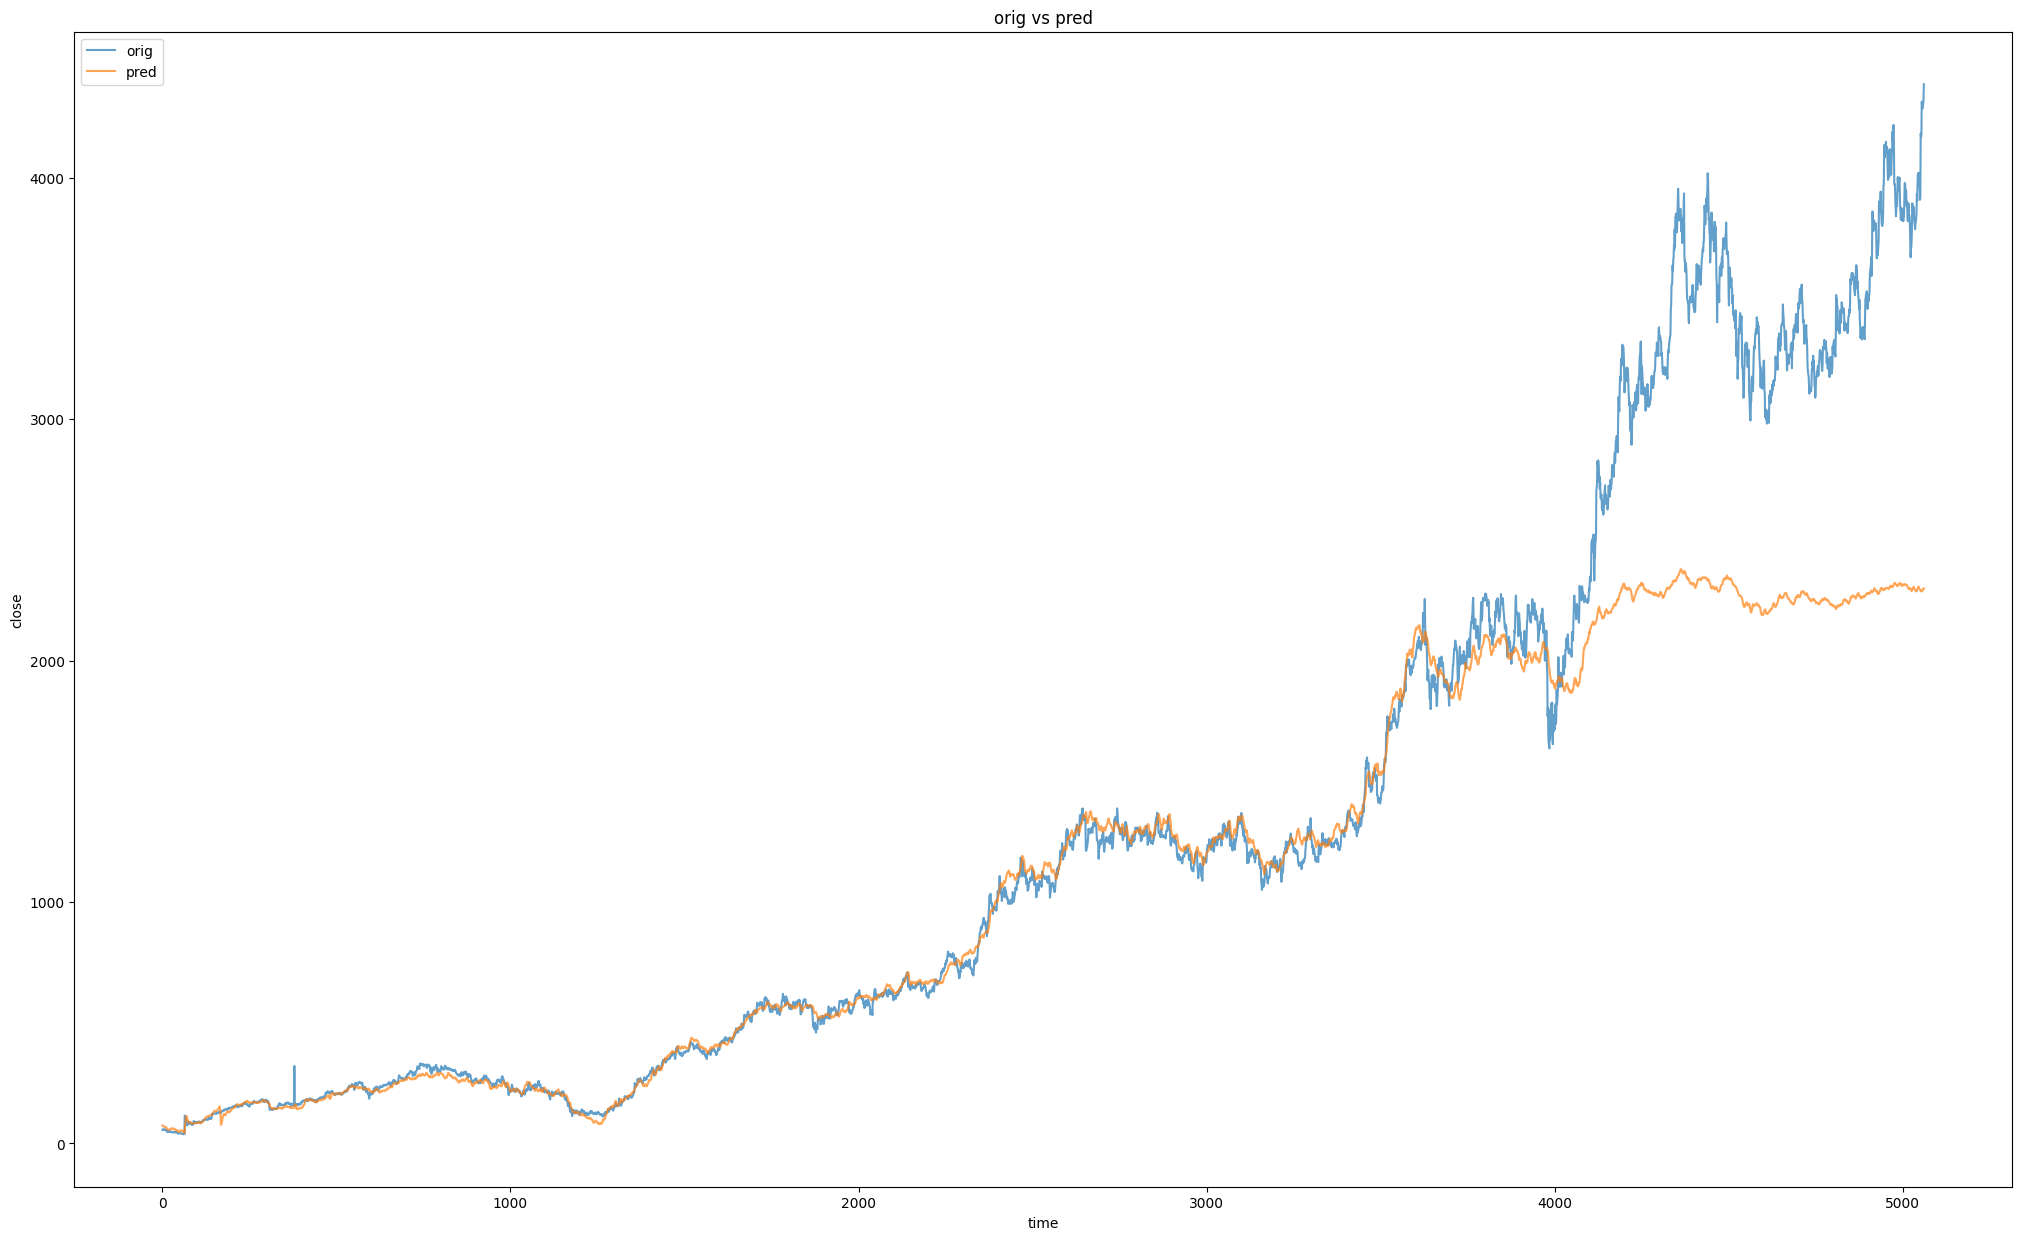

In [12]:

y_test_pred_scaled = model.predict(X_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_scaled)

plt.figure(figsize=(25, 15))
plt.plot(y_test_actual, label='orig', alpha=0.7)
plt.plot(y_test_pred, label='pred', alpha=0.7)
plt.title('orig vs pred')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


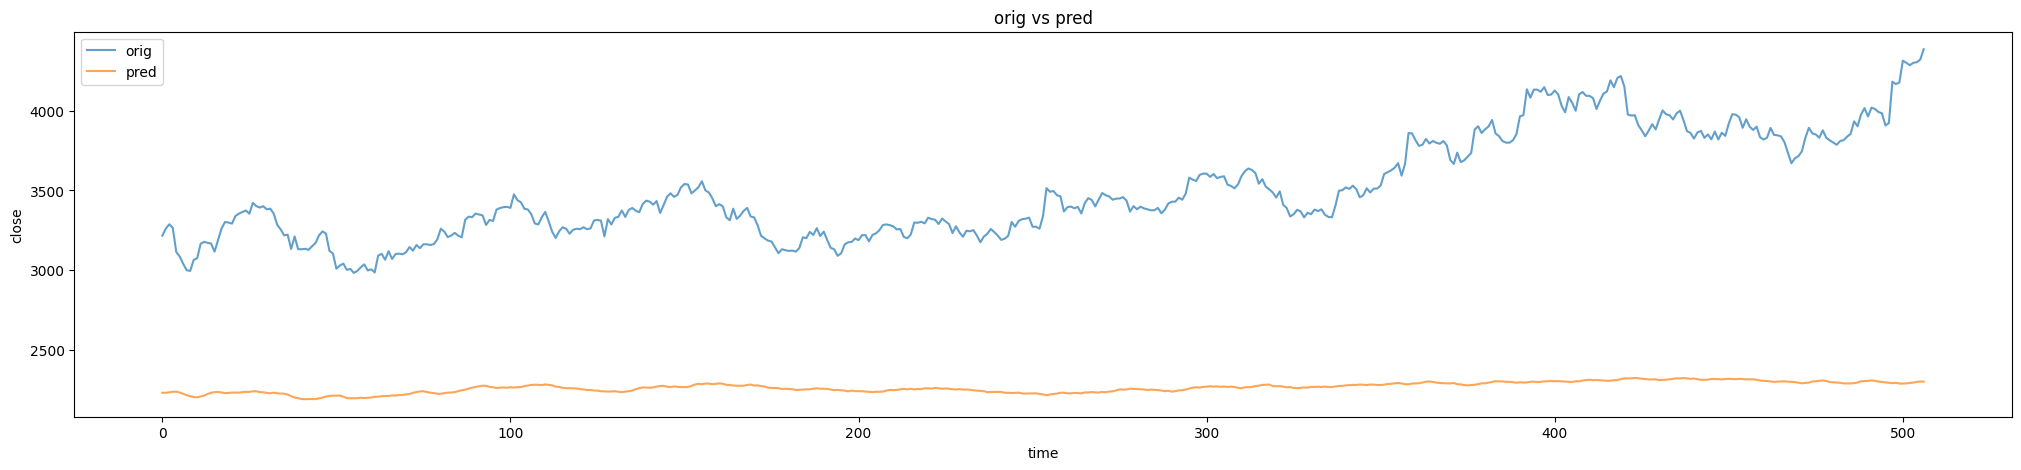

In [13]:
y_test_pred_scaled = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

plt.figure(figsize=(25, 5))
plt.plot(y_test_actual, label='orig', alpha=0.7)
plt.plot(y_test_pred, label='pred', alpha=0.7)
plt.title('orig vs pred')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()
plt.show()